In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import statsmodels.api as sm
import arviz as az

SEED = 100

# Multiple products

In [2]:
np.random.seed(SEED)
M = 25 # products
T = 750
mu_alpha = 2.
sig_alpha = 0.1
alpha = np.random.normal(mu_alpha, sig_alpha,size=M)

mu_decay = -1.5
sig_decay = 0.3
Bdecay = np.random.normal(mu_decay, sig_decay, size=M)

mu_bS = .75
sig_bS = 0.15
bS = np.random.normal(mu_bS, sig_bS, size=M)

sig_mu = 0.035
sig = np.random.normal(sig_mu, 0.001, size=M)

In [3]:
true_effects = {
    "alpha":alpha,
    "decay":Bdecay,
    "bS":bS,
    "AR":sig
}

In [5]:
np.random.seed(SEED)

t = np.arange(1, T+1)
seasonality = np.where( t//(365/2) % 2 == 0, 1, 0)
wave = (np.sin(t/(365/6.3))+1)/2
ar = np.random.normal(0, sig,size=(T,M)).cumsum(0)

mu = np.empty((M,T))*np.nan
y_mu = np.empty((M,T))*np.nan
y = np.empty((M,T))*np.nan

yt_minus1 = np.repeat(4, M)
for period in range(T):
    mu[:,period] = alpha + sig*np.log(1+yt_minus1) + Bdecay*(period/365) + bS*wave[period]
    y_mu[:,period] = np.exp(mu[:,period])
    y[:,period] = np.random.poisson(y_mu[:,period])
    yt_minus1 = y[:,period]
    
    
y = y.T
y_mu = y_mu.T

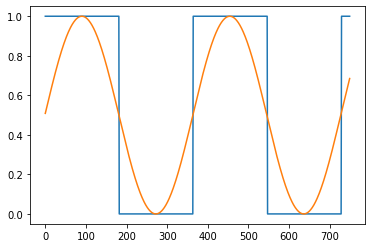

In [6]:
plt.plot(seasonality)
plt.plot( wave )

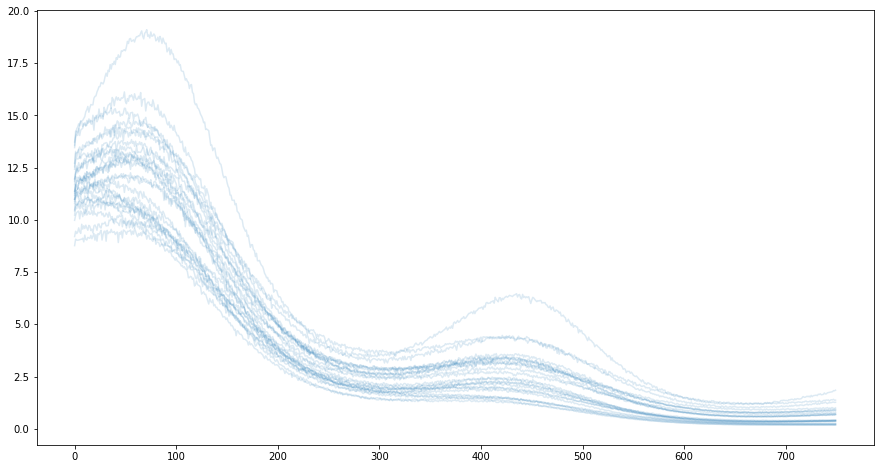

In [7]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(y_mu, alpha=0.15, color="C0");
# ax.plot(y, alpha=0.15, color="C0");

In [8]:
# plt.plot(np.arange(750, 1500), ar.T[1,:],alpha=0.5 )
# df.y_tminus1[750:1500].plot(alpha=0.5)

In [16]:
df = pd.DataFrame({
    "style":np.repeat([f"P{i}" for i in range(M)], T),
    "t":np.tile(t, M),
    "season":np.tile(wave,M),
    "y":y.T.ravel()
}).assign(y_tminus1 = lambda d: d.groupby("style").y.shift(1).bfill() )

df

,style,t,season,y,y_tminus1
0,P0,1,0.508630,12.0,12.0
1,P0,2,0.517257,10.0,12.0
2,P0,3,0.525879,9.0,10.0
3,P0,4,0.534493,9.0,9.0
4,P0,5,0.543097,9.0,9.0
...,...,...,...,...,...
18745,P24,746,0.652431,1.0,1.0
18746,P24,747,0.660627,3.0,1.0
18747,P24,748,0.668776,2.0,3.0
18748,P24,749,0.676874,3.0,2.0


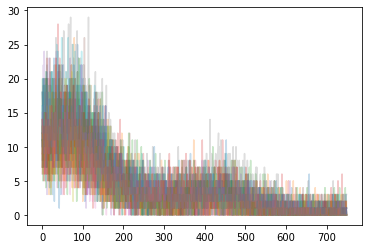

In [17]:
gpby = df.set_index(["style", "t"]).groupby("style")["y"]
gpby.plot(use_index=False,alpha=0.25);

# Frequentist model

In [18]:
model = sm.Poisson.from_formula("y ~ C(style)*(t+season) + y_tminus1", data=df).fit()
model.summary()


Optimization terminated successfully.
         Current function value: 1.766408
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                18750
Model:                        Poisson   Df Residuals:                    18674
Method:                           MLE   Df Model:                           75
Date:                Mon, 11 Apr 2022   Pseudo R-squ.:                  0.5083
Time:                        08:40:01   Log-Likelihood:                -33120.
converged:                       True   LL-Null:                       -67362.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.7837      0.063     28.452      0.000       1.661       1.907
C(style)[T.P1]             0.3628      0.083      4.370      0.000       0.200       0.526
C(style)[T.P10]            0.3745      0.091      4.129      0.000       0.197       0.552
C(style)[T.P11]            0.2972      0.081      3.667      0.000       0.138       0.456
C(style)[T.P12]            0.2920      0.096      3.033      0.002       0.103       0.481
C(style)[T.P13]            0.4838      0.091      5.321      0.000       0.306       0.662
C(style)[T.P14]            0.4057      0.092      4.388      0.000       0.225       0.587
C(style)[T.P15]            0.3273      0.090      3.631      0.000       0.151       0.504
C(style)[T.P16]            0.2497      0.090      2.777      0.005       0.073       0.426
C(style)[T.P17]            0.3568      0.083      4.273      0.000       0.193       0.520
C(style)[T.P18]            0.2615      0.089      2.951      0.003       0.088       0.435
C(style)[T.P19]            0.1606      0.085      1.894      0.058      -0.006       0.327
C(style)[T.P2]             0.3664      0.080      4.606      0.000       0.211       0.522
C(style)[T.P20]            0.3824      0.095      4.020      0.000       0.196       0.569
C(style)[T.P21]            0.4438      0.086      5.141      0.000       0.275       0.613
C(style)[T.P22]            0.1828      0.086      2.131      0.033       0.015       0.351
C(style)[T.P23]            0.3481      0.097      3.579      0.000       0.157       0.539
C(style)[T.P24]            0.3183      0.078      4.086      0.000       0.166       0.471
C(style)[T.P3]             0.2991      0.090      3.323      0.001       0.123       0.476
C(style)[T.P4]             0.4038      0.084      4.796      0.000       0.239       0.569
C(style)[T.P5]             0.3901      0.084      4.664      0.000       0.226       0.554
C(style)[T.P6]             0.3006      0.094      3.192      0.001       0.116       0.485
C(style)[T.P7]             0.0252      0.092      0.276      0.783      -0.154       0.205
C(style)[T.P8]             0.2186      0.084      2.613      0.009       0.055       0.383
C(style)[T.P9]             0.3743      0.084      4.457      0.000       0.210       0.539
t                         -0.0033      0.000    -28.100      0.000      -0.003      -0.003
C(style)[T.P1]:t          -0.0004      0.000     -2.526      0.012      -0.001   -8.81e-05
C(style)[T.P10]:t         -0.0015      0.000     -8.120      0.000      -0.002      -0.001
C(style)[T.P11]:t       5.876e-05      0.000      0.394      0.694      -0.000       0.000
C(style)[T.P12]:t         -0.0025      0.000    -12.795      0.000      -0.003      -0.002
C(style)[T.P13]:t         -0.0023      0.000    -12.696      0.000      -0.003      -0.002
C(style)[T.P14]:t         -0.0018      0.000     -9.783      0.000      -0.002      -0.001
C(style)[T.P15]:t         -0.0015      0.000     -8.296 

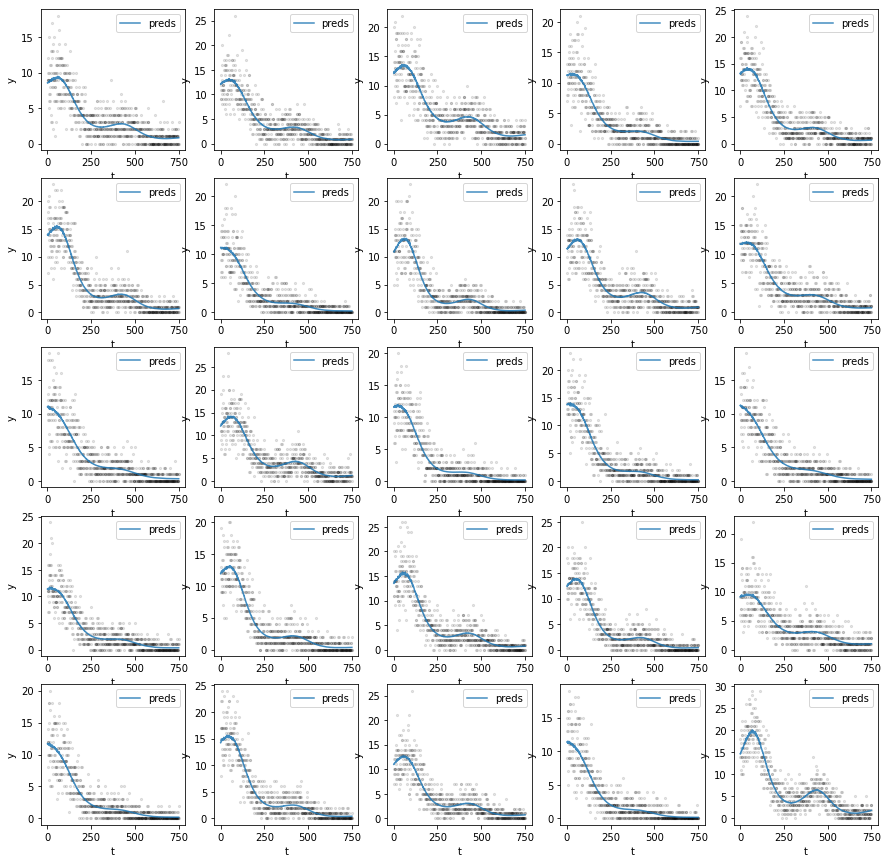

In [19]:
fig, axs = plt.subplots(5,5,figsize=(15,15))

res = (df.assign(yhat = model.predict(df))
         .set_index(["style", "t"])
         
)

for i, ax in zip(range(25), axs.ravel()):
#     res.loc[f"P{i}"].y.plot(ax=ax, alpha=0.25)
    res.loc[f"P{i}"].reset_index().plot.scatter(x="t", y="y", ax=ax, alpha=0.1, color="k", s=5)
    res.loc[f"P{i}"].yhat.plot(ax=ax, alpha=0.85, label="preds")
    ax.legend()

# Bayesian Model

In [20]:
import pymc3 as pm

In [21]:
s_, s_labels = pd.factorize(df["style"])

coords={"style":s_labels}
with pm.Model(coords=coords) as m:
    alpha = pm.Normal("alpha", 2, 0.5, dims="style")
    bS = pm.Normal("bS", 0.75, .15, dims="style")
    gamma = pm.Normal("gamma", -1.5, 0.35, dims="style")
    bAR = pm.Normal("bAR", 0.025, 0.001)
    
    mu = pm.Deterministic("mu", alpha[s_] + bS[s_]*df.season.values + gamma[s_]*df.t.values/365 + bAR*np.log(df.y_tminus1+1) )
    lambd = pm.Deterministic("lambd", pm.math.exp(mu))
    rentals = pm.Poisson("rentals", lambd, observed=df.y.values)
    

### Prior Predictive Simulation

In [22]:
with m:
    prior_pred = pm.sample_prior_predictive()

/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_59288/4269814647.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)
/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_59288/4269814647.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)
/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_59288/4269814647.py:17: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)


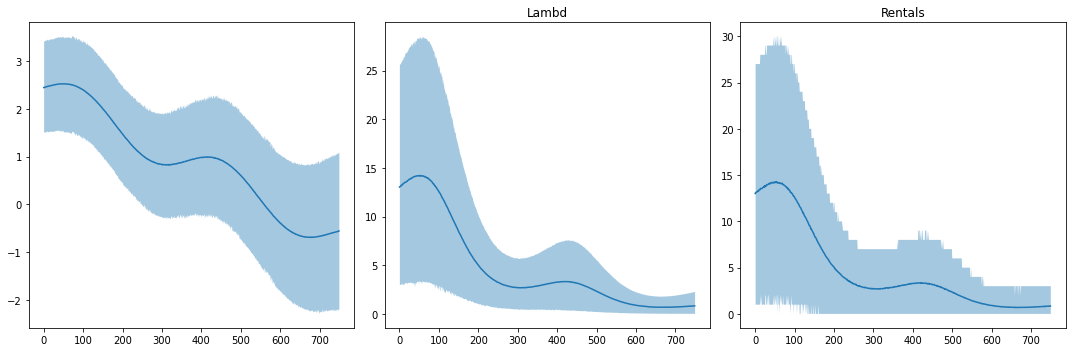

In [23]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[1].set_title("mu")
arr = prior_pred["mu"].reshape(500*M, (T))
bounds = az.hdi(arr)
ax[0].plot(arr.mean(0))
ax[0].fill_between(np.arange(1,T+1), bounds[:,0], bounds[:,1], alpha=0.4)

ax[1].set_title("Lambd")
arr = prior_pred["lambd"].reshape(500*M, (T))
bounds = az.hdi(arr)
ax[1].plot(arr.mean(0))
ax[1].fill_between(np.arange(1,T+1), bounds[:,0], bounds[:,1], alpha=0.4)

ax[2].set_title("Rentals")
arr = prior_pred["rentals"].reshape(500*M, (T))
bounds = az.hdi(arr)
ax[2].plot(arr.mean(0))
ax[2].fill_between(np.arange(1,T+1), bounds[:,0], bounds[:,1], alpha=0.4)
plt.tight_layout()

In [24]:
with m:
    trace = pm.sample(init="advi+adapt_diag", 
                      return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 16000
Interrupted at 15,999 [7%]: Average Loss = 1.2079e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bAR, gamma, bS, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.


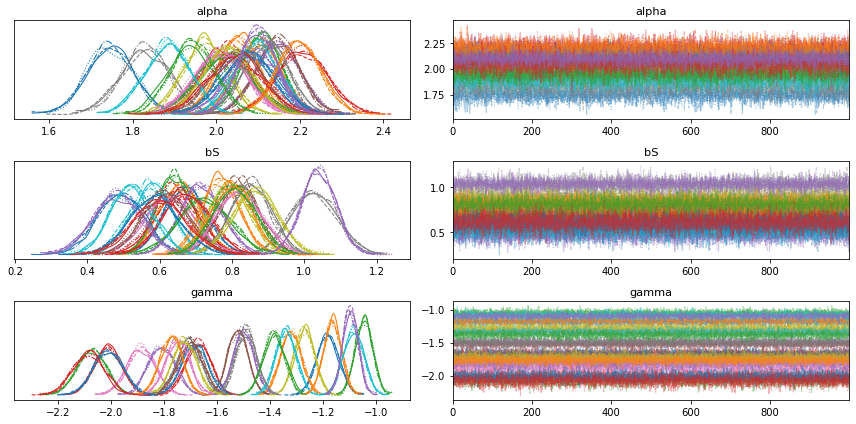

In [25]:
pm.plot_trace(trace, var_names=["alpha", "bS", "gamma"])
plt.tight_layout()

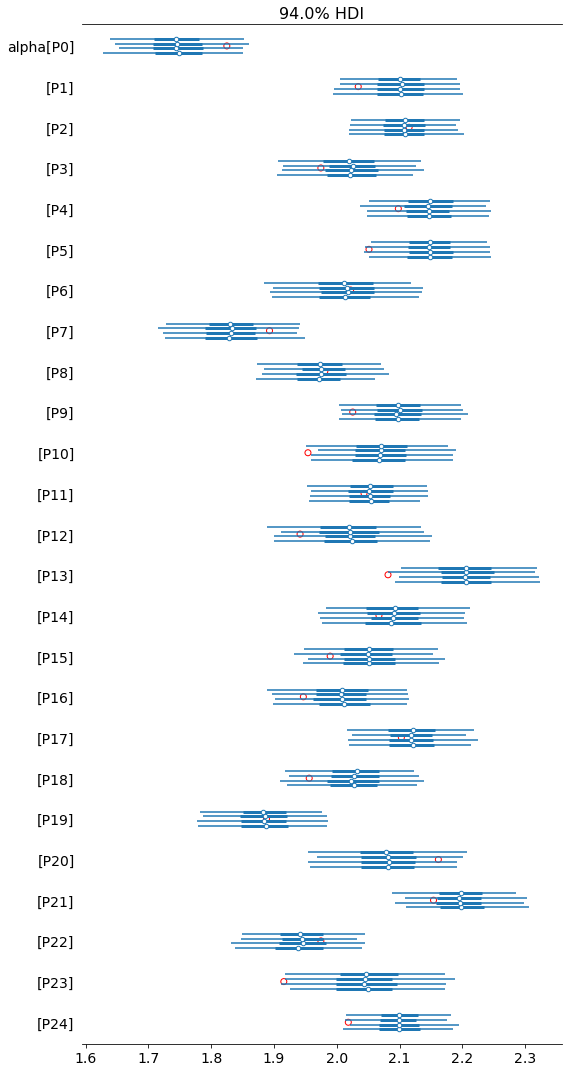

In [26]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace, var_names=["alpha"], ax=ax )
ax.scatter( true_effects["alpha"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

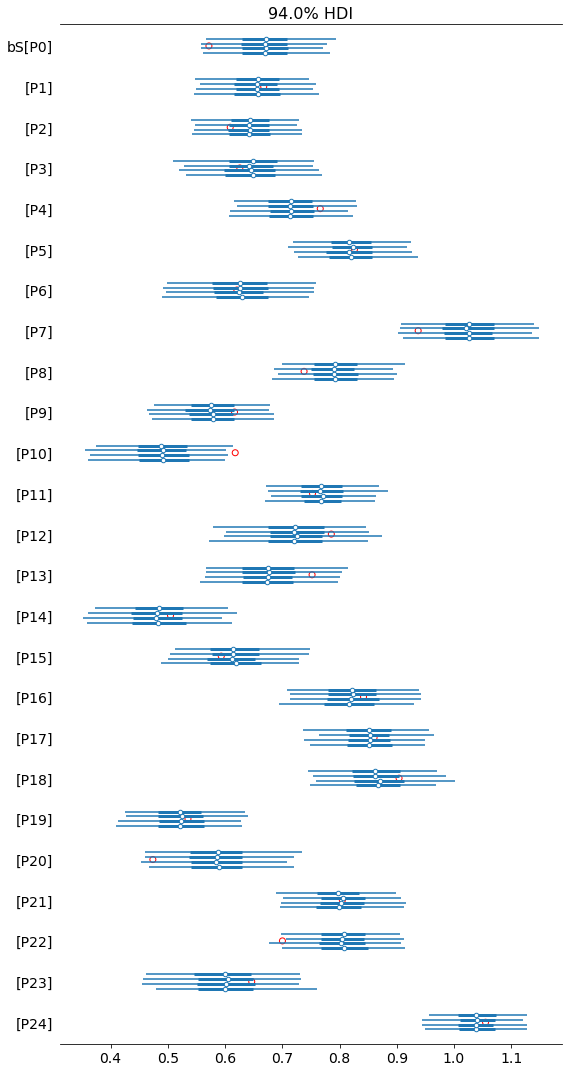

In [27]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace, var_names=["bS"], ax=ax )
ax.scatter( true_effects["bS"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

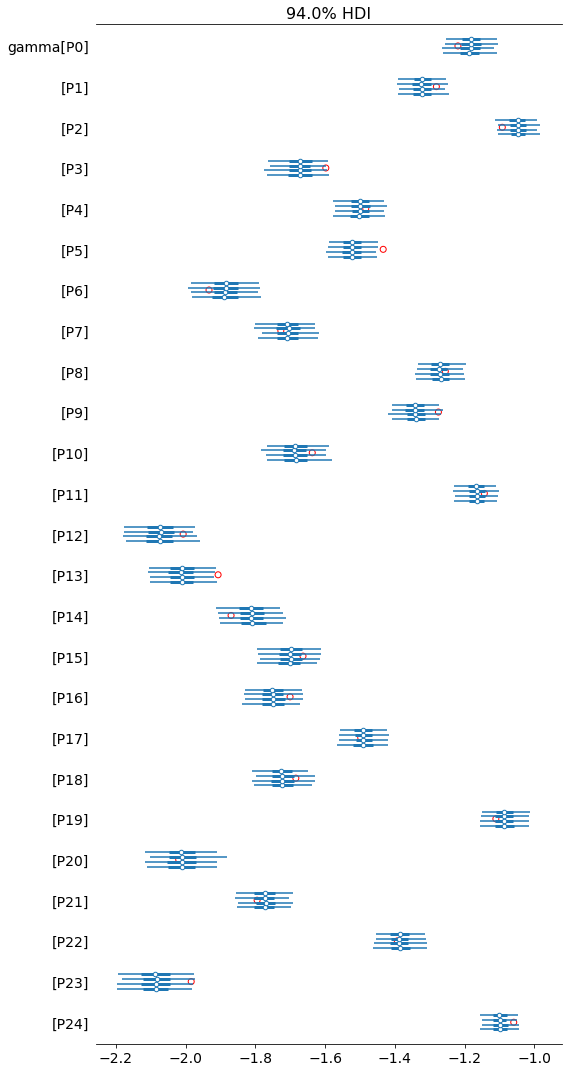

In [28]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace, var_names=["gamma"], ax=ax )
ax.scatter( true_effects["decay"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

# Hierarchical Model

In [29]:
def hierarchical_normal(name, dims, μ=0.):
    Δ = pm.Normal('Δ_{}'.format(name), 0., 0.001, dims=dims)
    σ = pm.Exponential('σ_{}'.format(name), 0.1)
    
    return pm.Deterministic(name, μ + Δ * σ)

In [65]:
with pm.Model(coords=coords) as m2:
    mu_alpha = pm.Normal("mu_alpha", 2, 0.5)
    alpha = hierarchical_normal("alpha", dims="style", μ=mu_alpha)
    
    mu_bS = pm.Normal("mu_bS", 0.75, .2)
    bS = hierarchical_normal("bS", dims="style", μ=mu_bS)

    mu_gamma = pm.Normal("mu_gamma", -5, 1.5)
    gamma = hierarchical_normal("gamma", dims="style", μ=mu_gamma)

    bAR = pm.Normal("bAR", 0.04, 0.01)
    mu = pm.Deterministic("mu", alpha[s_] + bS[s_]*df.season.values + gamma[s_]*df.t.values/365 + bAR*np.log(df.y_tminus1+1) )
    lambd = pm.Deterministic("lambd", pm.math.exp(mu))
    rentals = pm.Poisson("rentals", lambd, observed=df.y)
    

### Prior predictive

In [66]:
nsamples=1000
with m2:
    prior_pred = pm.sample_prior_predictive(nsamples)

/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_59288/1399281028.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)
/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_59288/1399281028.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)
/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_59288/1399281028.py:17: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)


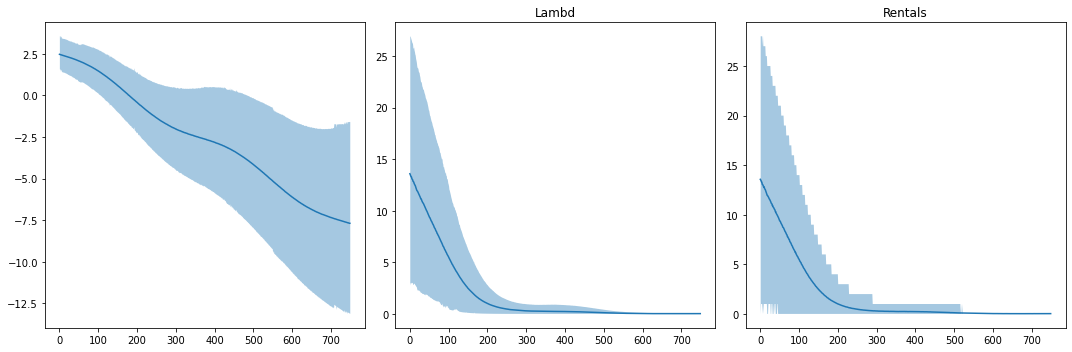

In [67]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[1].set_title("mu")
arr = prior_pred["mu"].reshape(nsamples*M, T)
bounds = az.hdi(arr)
ax[0].plot(arr.mean(0))
ax[0].fill_between(np.arange(1,T+1), bounds[:,0], bounds[:,1], alpha=0.4)

ax[1].set_title("Lambd")
arr = prior_pred["lambd"].reshape(nsamples*M, T)
bounds = az.hdi(arr)
ax[1].plot(arr.mean(0))
ax[1].fill_between(np.arange(1,T+1), bounds[:,0], bounds[:,1], alpha=0.4)

ax[2].set_title("Rentals")
arr = prior_pred["rentals"].reshape(nsamples*M, T)
bounds = az.hdi(arr)
ax[2].plot(arr.mean(0))
ax[2].fill_between(np.arange(1,T+1), bounds[:,0], bounds[:,1], alpha=0.4)
plt.tight_layout()

### Fit Model

In [68]:
with m2:
    trace2 = pm.sample(init="advi+adapt_diag", return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 68000
Interrupted at 67,999 [33%]: Average Loss = 7.6952e+85
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bAR, σ_gamma, Δ_gamma, mu_gamma, σ_bS, Δ_bS, mu_bS, σ_alpha, Δ_alpha, mu_alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 179 seconds.
The number of effective samples is smaller than 25% for some parameters.


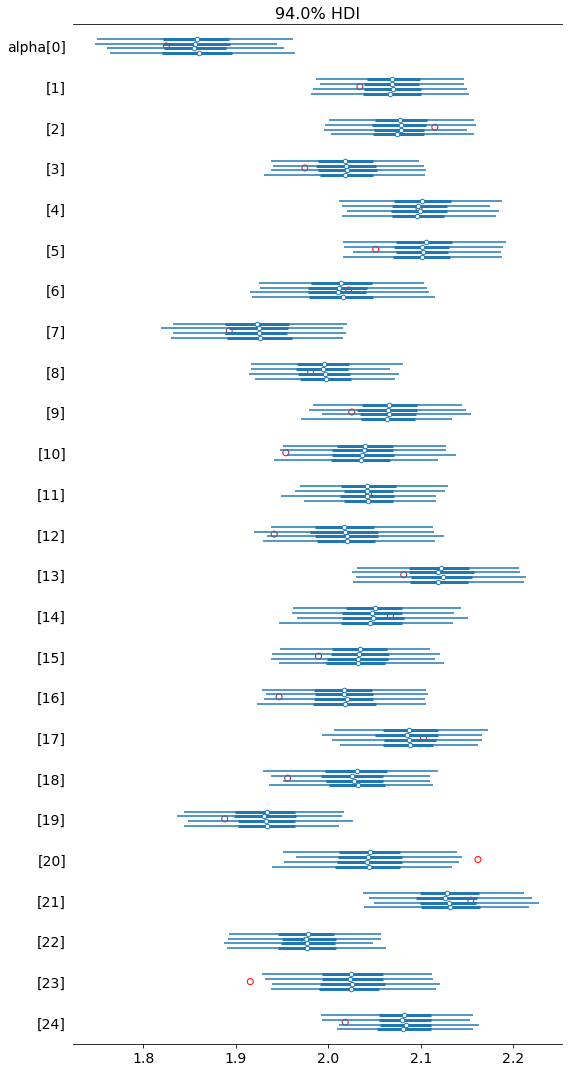

In [69]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace2, var_names=["alpha"], ax=ax )
ax.scatter( true_effects["alpha"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

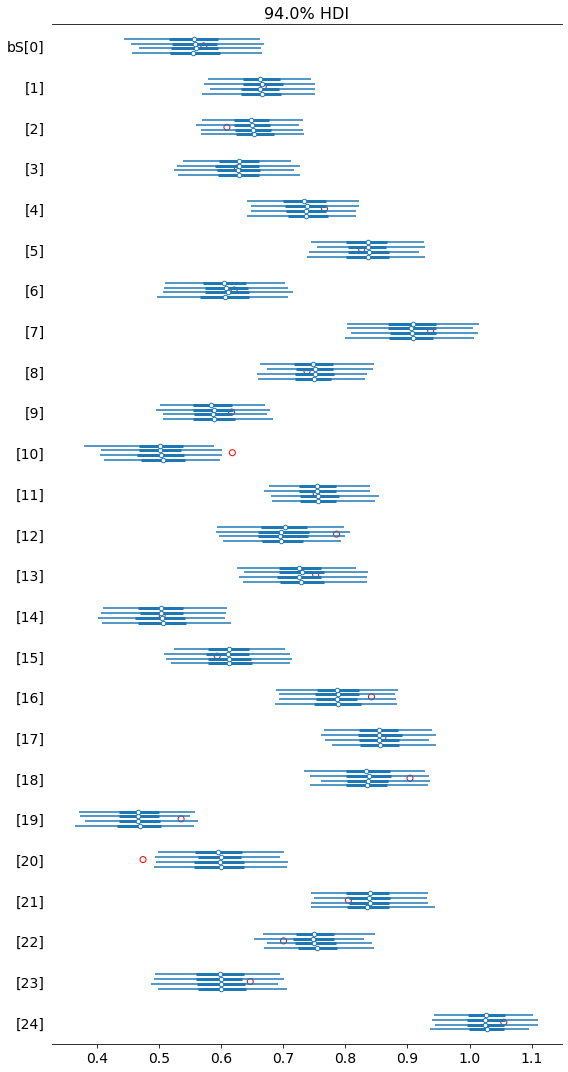

In [70]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace2, var_names=["bS"], ax=ax )
ax.scatter( true_effects["bS"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

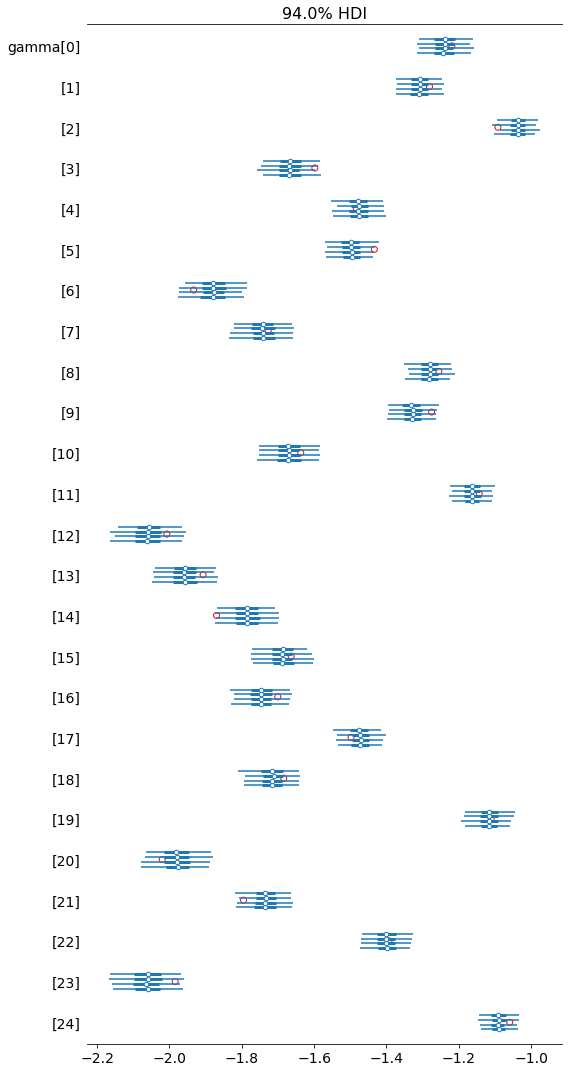

In [71]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace2, var_names=["gamma"], ax=ax )
ax.scatter( true_effects["decay"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

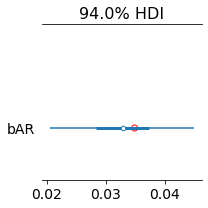

In [72]:
fig ,ax = plt.subplots(1,1,figsize=(3, 3))
pm.plot_forest( trace2, var_names=["bAR"], ax=ax, combined=True )
ax.scatter( true_effects["AR"].mean(), ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

In [73]:
with m2:
    preds = pm.sample_posterior_predictive(trace2)

In [74]:
yhat = preds["rentals"].reshape(4000, -1, T)


/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_59288/1066006978.py:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)


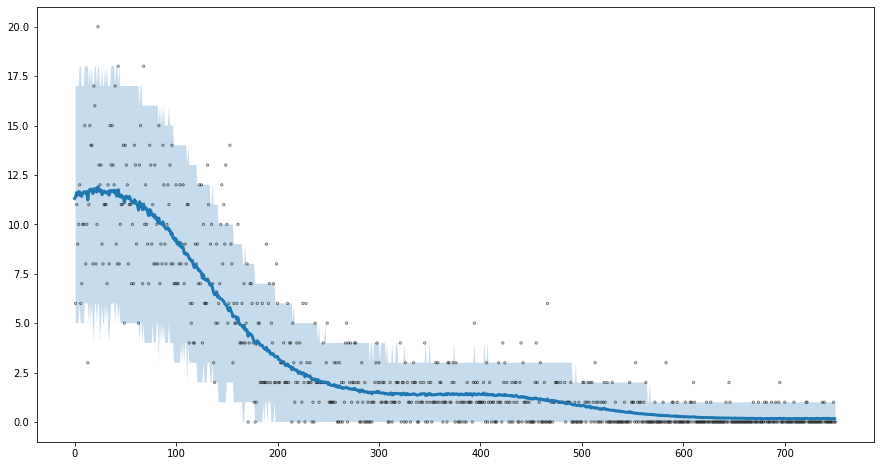

In [76]:


idx = np.random.choice(M)
arr = yhat[:,idx,:]
bounds = az.hdi(arr)

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(arr.mean(0), lw=3)
ax.fill_between(t, bounds[:,0], bounds[:,1], alpha=0.25)
ax.scatter(t, df.loc[lambda d: d["style"]==f"P{idx}"].y, 
            edgecolor="k",facecolor="none", alpha=0.5, s=5)